In [1]:
import xarray as xr
import pandas as pd
import numpy as np

In [7]:
import seaborn as sns

import sys
sys.path.append('./..')
from refuelplot import *
setup()
sns.set_style("darkgrid")

from paths_zaf import *

In [9]:
def read_ZAFprod():
    '''
    function for reading production data from csv
     replace month names and convert to datetime format
    '''
    files = ['/Hourly_Distribution_data_NZ.csv',
             '/Hourly_Electricity_Production_[Load_Factor_[[%]]_data_EasternCape.csv',
             '/Hourly_Electricity_Production_[Load_Factor_[[%]]_data_NorthernCape.csv',
             '/Hourly_Electricity_Production_[Load_Factor_[[%]]_data_WesternCape.csv']
    regions = ['ZAF','Eastern Cape','Northern Cape','Western Cape']
    months = {' Januar ':'01.',
              ' Februar ':'02.',
              ' März ':'03.',
              ' April ':'04.',
              ' Mai ':'05.',
              ' Juni ':'06.',
              ' Juli ':'07.',
              ' August ':'08.',
              ' September ':'09.',
              ' Oktober ':'10.',
              ' November ':'11.',
              ' Dezember ':'12.'}
    starts = [None,'2014-06-15','2017-10-10',None] # cut bad starts of time series
    prod_ZAF = []
    for (file,region,start) in zip(files,regions,starts):
        ZAF = pd.read_csv(zaf_path + file,sep=';',parse_dates=[1])
        ZAF.columns =  ['year','date','technology','CF']
        ZAF = ZAF[ZAF.technology=='Onshore Wind\r\n'].drop(['technology','year'],axis=1)
        for month in months:
            ZAF.date = ZAF.date.str.replace(month,months.get(month)) # replace months by numbers
        ZAFdf = pd.Series(ZAF.CF.values,
                          index=pd.to_datetime(ZAF.date).values,
                          name=region).sort_index()
        if(start != None):
            ZAFdf = ZAFdf[start:]
        prod_ZAF.append(ZAFdf)
    return(pd.concat(prod_ZAF,axis=1).tz_localize('Africa/Johannesburg'))

def load_results(dataset,gwa,regions):
    '''
    function for loading simulation results
     dataset is either MERRA2 or ERA5
     gwa is none, GWA2 or GWA3
    '''
    if gwa == 'GWA2':
        rpath = results_path + '/results_GWA2/'
    else:
        rpath = results_path + '/'
    if gwa == 'none':
        file = 'windpower_ZAF_'+dataset+'.nc'
    else:
        file = 'windpower_ZAF_'+dataset+'_GWA.nc'
    ZAF = xr.open_dataset(rpath + file).wp.to_dataframe().reset_index().set_index(['time','location']).unstack()
    # adapt datetime index of MERRA data (some hours are shifted by 30 min)
    if dataset == 'MERRA2':
        ZAF.index.values[ZAF.index.minute!=0] = ZAF.index.values[ZAF.index.minute!=0] - np.timedelta64(30,'m')
    # sum up per region
    ZAF = ZAF.groupby(regions,axis=1).sum(axis=1).tz_localize('UTC')
    ZAF['ZAF'] = ZAF.sum(axis=1)
    return(ZAF)

def get_cap_df(cap,comdate):
    '''
    function for getting hourly capacities
     cap is numpy array of installed capacities
     comdate is numpy array of commissioning dates in datetime format
    '''
    com = pd.DataFrame({'capacity': cap}).groupby(comdate).sum()
    cap_cum = com.capacity.cumsum()
    # if only years given for commissioning dates -> gradual capacity increase over year, full capacity at end of year
    dr = pd.date_range('1/1/2013','31/12/2019 23:00:00',freq = 'h')
    cap_ts = pd.Series(dr.map(cap_cum),index = dr)
    cap_ts[0] = cap_cum[cap_cum.index<=pd.Timestamp('2013-01-01')].max()
    if type(comdate[0]) == np.int64:
        return(cap_ts.interpolate(method='linear'))
    else:
        return(cap_ts.fillna(method='ffill'))

def gcdH(region):
    '''
    function to get capacity time series for a region
    '''
    cap = windparks[windparks.Area==region].Capacity.values
    com = windparks[windparks.Area==region].commissioning.astype(np.datetime64).values
    cdf = get_cap_df(cap,com).tz_localize('UTC')
    cdf.name = region
    return(cdf)

def getH(region):
    '''
    analyse hourly wind power generation for a region
    '''
    comph = pd.DataFrame({'MERRA2':ZAFm[region],
                         'ERA5':ZAFe[region],
                         'MERRA2_GWA2':ZAFmg2[region],
                         'ERA5_GWA2':ZAFeg2[region],
                         'MERRA2_GWA3':ZAFmg3[region],
                         'ERA5_GWA3':ZAFeg3[region]})
    # get capacities
    caph = capdfH[region]
    # calculate capacity factors
    cfh = comph.div(caph,axis=0).tz_convert('Africa/Johannesburg')
    # add observed data
    cfh['obs'] = cfh.index.map(ZAFh[region])
    # remove capacity factors > 1 and lines with missing data
    cfh = cfh.mask(cfh>1).dropna()
    return(cfh)

def getD(region):
    '''
    analyse daily wind power generation for a region
    '''
    mask = (ZAFh[region].notna()*capdfH[region].notna()).replace(0,np.nan)
    comph = pd.DataFrame({'MERRA2':ZAFm[region].tz_convert('Africa/Johannesburg')*mask,
                         'ERA5':ZAFe[region].tz_convert('Africa/Johannesburg')*mask,
                         'MERRA2_GWA2':ZAFmg2[region].tz_convert('Africa/Johannesburg')*mask,
                         'ERA5_GWA2':ZAFeg2[region].tz_convert('Africa/Johannesburg')*mask,
                         'MERRA2_GWA3':ZAFmg3[region].tz_convert('Africa/Johannesburg')*mask,
                         'ERA5_GWA3':ZAFeg3[region].tz_convert('Africa/Johannesburg')*mask})
    # get capacities and mask
    caph = capdfH[region].tz_convert('Africa/Johannesburg')*mask
    # aggregate daily
    capd = caph.resample('D').sum()
    compd = comph.resample('D').sum()
    # calculate capacity factors
    cfd = compd.div(capd,axis=0)
    # add observed CFs
    cfd['obs'] = cfd.index.map((ZAFh[region]*mask).resample('D').mean())
    # remove capacity factors > 1 and missing data
    cfd = cfd.mask(cfd>1).dropna()
    return(cfd)

def getM(region):
    '''
    analyse monthly wind power generation for a region
    '''
    # mask for masking simulated data and capacities
    # (to only use timespans where also observed data are available)
    mask = (ZAFh[region].notna()*capdfH[region].notna()).replace(0,np.nan)
    comph = pd.DataFrame({'MERRA2':ZAFm[region].tz_convert('Africa/Johannesburg')*mask,
                         'ERA5':ZAFe[region].tz_convert('Africa/Johannesburg')*mask,
                         'MERRA2_GWA2':ZAFmg2[region].tz_convert('Africa/Johannesburg')*mask,
                         'ERA5_GWA2':ZAFeg2[region].tz_convert('Africa/Johannesburg')*mask,
                         'MERRA2_GWA3':ZAFmg3[region].tz_convert('Africa/Johannesburg')*mask,
                         'ERA5_GWA3':ZAFeg3[region].tz_convert('Africa/Johannesburg')*mask})
    # get capacities and mask
    caph = capdfH[region].tz_convert('Africa/Johannesburg')*mask
    # aggregate monthly
    capm = caph.resample('M').sum()
    compm = comph.resample('M').sum()
    # calculate capacity factors
    cfm = compm.div(capm,axis=0)
    # add observed data
    cfm['obs'] = cfm.index.map((ZAFh[region]*mask).resample('M').mean())
    # remove capacity factors > 1 and missing data
    cfm = cfm.mask(cfm>1).dropna()
    return(cfm)


In [15]:
## Analysis
# load windpark data
print('prepare windparks')
windparks = pd.read_csv(zaf_path + "/windparks_ZAF.csv", parse_dates=['commissioning'])

# load observed data
print('load observed data')
ZAFh = read_ZAFprod()

# get capacitiy time series for all parks
print('get capacities')
capes = ['Eastern Cape','Western Cape','Northern Cape']
capdfCH = pd.Series(capes,index = capes).apply(gcdH).transpose()
capdfZH = get_cap_df(windparks.Capacity.values,windparks.commissioning.astype(np.datetime64).values).tz_localize('UTC')
capdfZH.name = 'ZAF'
capdfH = pd.concat([capdfCH,capdfZH],axis = 1)

# load simulated data
print('load simulated data')
ZAFm = load_results('MERRA2','none',windparks.Area.values)
ZAFmg2 = load_results('MERRA2','GWA2',windparks.Area.values)
ZAFmg3 = load_results('MERRA2','GWA3',windparks.Area.values)
ZAFe = load_results('ERA5','none',windparks.Area.values)
ZAFeg2 = load_results('ERA5','GWA2',windparks.Area.values)
ZAFeg3 = load_results('ERA5','GWA3',windparks.Area.values)

prepare windparks
load observed data
get capacities
load simulated data


In [16]:
ZAFH = getH('ZAF')

In [17]:
ZAFM = getM('ZAF')

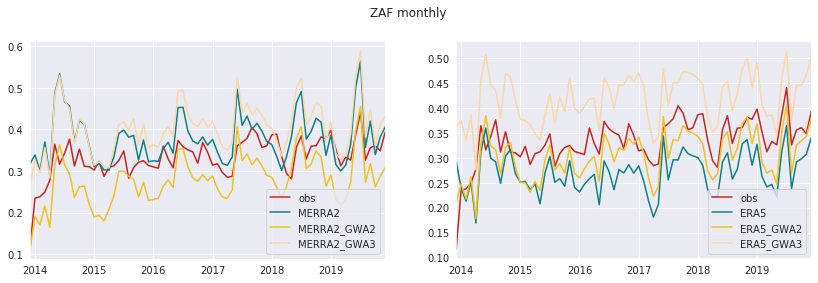

In [25]:
fig, axs = plt.subplots(1,2,figsize=(14,4))
fig.suptitle('ZAF monthly',y=1.001)
sims = [['obs','MERRA2','MERRA2_GWA2','MERRA2_GWA3'],['obs','ERA5','ERA5_GWA2','ERA5_GWA3']]
for i in range(len(sims)):
    ZAFM[sims[i]].plot(ax = axs[i])

why is GWA2 closer to ERA5 but GWA3 closer to MERRA2? shouldn't it be the other way round? (GWA2 is based on MERRA2, GWA3 is based on ERA5)

In [26]:
NCM = getM('Northern Cape')

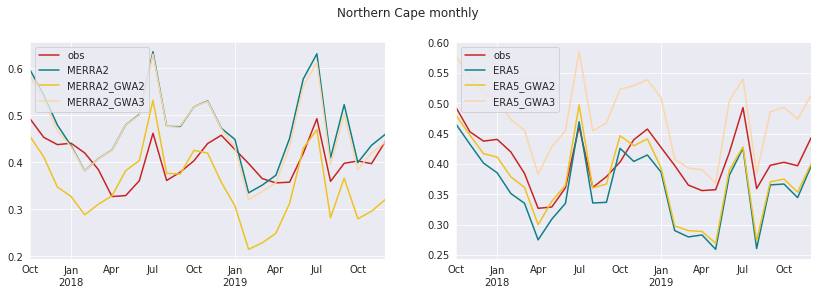

In [27]:
fig, axs = plt.subplots(1,2,figsize=(14,4))
fig.suptitle('Northern Cape monthly',y=1.001)
sims = [['obs','MERRA2','MERRA2_GWA2','MERRA2_GWA3'],['obs','ERA5','ERA5_GWA2','ERA5_GWA3']]
for i in range(len(sims)):
    NCM[sims[i]].plot(ax = axs[i])

In [28]:
ECM = getM('Eastern Cape')

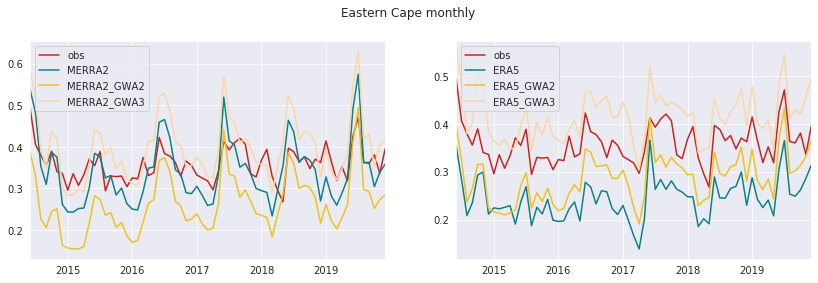

In [30]:
fig, axs = plt.subplots(1,2,figsize=(14,4))
fig.suptitle('Eastern Cape monthly',y=1.001)
sims = [['obs','MERRA2','MERRA2_GWA2','MERRA2_GWA3'],['obs','ERA5','ERA5_GWA2','ERA5_GWA3']]
for i in range(len(sims)):
    ECM[sims[i]].plot(ax = axs[i])

In [31]:
WCM = getM('Western Cape')

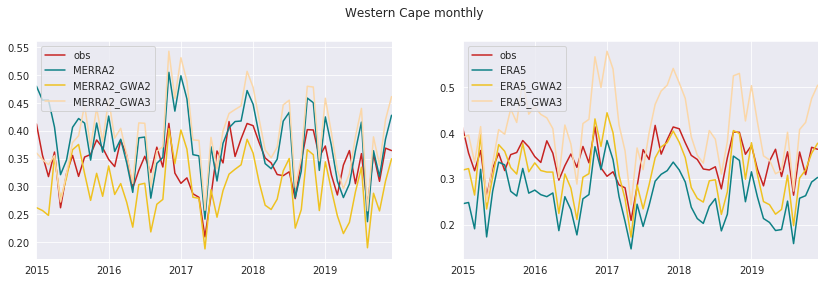

In [32]:
fig, axs = plt.subplots(1,2,figsize=(14,4))
fig.suptitle('Western Cape monthly',y=1.001)
sims = [['obs','MERRA2','MERRA2_GWA2','MERRA2_GWA3'],['obs','ERA5','ERA5_GWA2','ERA5_GWA3']]
for i in range(len(sims)):
    WCM[sims[i]].plot(ax = axs[i])

In [ ]:
# analyse results
# hourly
print('analyse hourly')
resZAFh = pd.concat(pd.Series(['ZAF']+capes).apply(analyse_ZAFh).to_list(),axis=0)
# daily
print('analyse daily')
resZAFd = pd.concat(pd.Series(np.unique(['ZAF']+capes)).apply(analyse_ZAFd).to_list(),axis=0)
# monthly
print('analyse monthly')
resZAFm = pd.concat(pd.Series(np.unique(['ZAF']+capes)).apply(analyse_ZAFm).to_list(),axis=0)

# tidy and merge results
print('tidy and merge results')
rZAFh = tidy_res(resZAFh,'h')
rZAFd = tidy_res(resZAFd,'d')
rZAFm = tidy_res(resZAFm,'m')
results = pd.concat([rZAFh,rZAFd,rZAFm],axis=0)
results['ds'] = results.dataset.str.split('_').apply(lambda x: x[0])
results['GWA'] = (results.dataset.str.split('_')+['none']).apply(lambda x: x[1])
# save results
print('save results')
results.to_csv(results_path + '/statZAF.csv')